Modello 'vit-base-HAM-10000-patch-32' addestrato su HAM10000:

In [ ]:
#INSTALLAZIONE DELLE LIBRERIE
!pip install transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn.functional as F
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

#ACCESSO A DRIVE
drive.mount('/content/drive')
path_valutazione = "/content/drive/MyDrive/Tesi_Angelinetta_Lorenzo/ISIC_TEST"
path_csv = "/content/drive/MyDrive/Tesi_Angelinetta_Lorenzo/ISIC_labels.csv"
path_prova = "/content/drive/MyDrive/Tesi_Angelinetta_Lorenzo/Img_prova"
json_path = "/content/drive/MyDrive/Tesi_Angelinetta_Lorenzo/Salvataggi_JSON_finali/classificazione_ViT.json"

#RISORSE DI CALCOLO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#DIZIONARIO DELLE CLASSI PER AVERE IL NOME DELLA CLASSE IDENTIFICATA DA HAM10000
etichette_classi = {
    0: "Cheratosi attiniche e carcinoma intraepiteliale / malattia di Bowen (akiec)",
    1: "Carcinoma basocellulare (bcc)",
    2: "Lesioni benigne simili a cheratosi (bkl)",
    3: "Dermatofibroma (df)",
    4: "Melanoma (mel)",
    5: "Nevi melanocitici (nv)",
    6: "Lesioni vascolari (vasc)"
}

acronimo_classi = {0: "akiec", 1: "bcc", 2: "bkl", 3: "df", 4: "mel", 5: "nv", 6: "vasc"}
acronimo_classi_inverso = {"akiec": 0, "bcc": 1, "bkl": 2, "df": 3, "mel": 4, "nv": 5, "vasc": 6}

#CARICAMENTO DEL MODELLO HAM10000
nome_modello = "ahishamm/vit-base-HAM-10000-patch-32"
processore_img = ViTImageProcessor.from_pretrained(nome_modello) #caricamento processore immagini
model_ham10000 = ViTForImageClassification.from_pretrained(nome_modello) #caricamento modello

In [ ]:
#CERCA SE ESISTE FILE PER SALVATAGGIO ANALISI E NEL CASO LO RITORNA
def carica_dati():
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            return json.load(f)
    return {"valutate": []}

#SALVATAGGIO SU FILE NUOVA ANALISI
def salva_dati():
    with open(json_path, "w") as f:
        json.dump(dati, f, indent=4)

#CARICAMENTO DEL FILE CSV PER SCEGLIERE IMG
dati = carica_dati()
df = pd.read_csv(path_csv)  #selezione immagini
df = df.set_index("image") #nome dell'immagine sarà l'indice

img_test = sorted([os.path.join(path_valutazione, img) for img in os.listdir(path_valutazione) if img.lower().endswith(('png', 'jpg', 'jpeg'))]) #lista delle img ordinate
img_test = [img for img in img_test if img not in [d["img"] for d in dati["valutate"]]] #lista togliendo le img già valutate

#SALVATAGGIO DELL'ANALISI
with torch.no_grad(): #modalità valutazione
    for img_path in img_test:
        img_name = os.path.basename(img_path).split('.')[0] #nome immagine senza estensione

        if img_name in df.index: #verifico classificazione corretta nel csv
            classificazione_reale = df.loc[img_name].idxmax().lower() #Cerca tipo di lesione nel csv per quell'immagine
            classificazione_reale_numerica = acronimo_classi_inverso.get(classificazione_reale) #converte in numero

        img = Image.open(img_path)
        inputs = processore_img(images=img, return_tensors="pt").to(device)
        outputs = model_ham10000(**inputs)
        logits = outputs.logits

        classificazione_vit_numerica = torch.argmax(logits, dim=-1).item()
        classificazione_vit = etichette_classi[classificazione_vit_numerica]

        print(f"Image: {img_path} - ViT: {classificazione_vit} - Real class: {classificazione_reale}")

        dati["valutate"].append({
                "img": img_path,
                "reale": "lesione cutanea",
                "classe_giusta": classificazione_reale,
                "classe_giusta_numerica": classificazione_reale_numerica,
                "classificazione_vit": classificazione_vit,
                "classificazione_vit_numerica": classificazione_vit_numerica
        })
        salva_dati()
    print("The list of image is finished. Check the metrics value.")


The list of image is finished. Check the metrics value.


NUMBER OF IMAGES ANALYZED: 1511

Accuracy classification: 74.78%

Confusion Matrix Classification ViT:



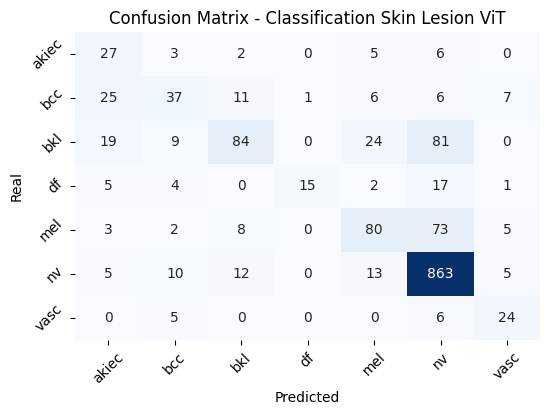

In [ ]:
if not dati["valutate"]:
    print("No data available for metric calculation.")
    exit()

# Estraggo le etichette reali e predette con i nomi delle classi
reale = [d["classe_giusta_numerica"] for d in dati["valutate"]]
predetto = [d["classificazione_vit_numerica"] for d in dati["valutate"]]

# Calcolo le metriche
accuracy = accuracy_score(reale, predetto)
conf_matrix = confusion_matrix(reale, predetto)

# Stampa delle metriche e grafico
print(f"NUMBER OF IMAGES ANALYZED: {len(reale)}\n")
print(f"Accuracy classification: {accuracy * 100:.2f}%\n")
print("Confusion Matrix Classification ViT:\n")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[acronimo_classi[i] for i in list(acronimo_classi.keys())],
            yticklabels=[acronimo_classi[i] for i in list(acronimo_classi.keys())])
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix - Classification Skin Lesion ViT")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
#CONTA DA CSV IL NUMERO DI IMMAGINI PER CLASSE
import pandas as pd

df = pd.read_csv(path_csv)
conteggio_classi = df.iloc[:, 1:].sum()
print(conteggio_classi)

MEL      171.0
NV       908.0
BCC       93.0
AKIEC     43.0
BKL      217.0
DF        44.0
VASC      35.0
dtype: float64


Prova funzionamento con una sola foto

In [ ]:
#PREPARAZIONE IMMAGINE
percorso_img = path_prova + "/mel.jpg"
img = Image.open(percorso_img)
inputs = processore_img(images=img, return_tensors="pt") #preprocessa img prima di passarla al modello restituendo un tensore

#ESECUZIONE DEL MODELLO
with torch.no_grad(): #disattivo gradienti per modalità valutazione
    outputs = model_ham10000.vit(**inputs) #passo img pre-processata (tensore) al modello per ottenere i risultati

features = outputs.last_hidden_state[:, 0, :] #features penultimo strato
logits = model_ham10000(**inputs).logits #tensore delle probabilità di ciascuna classe (valore più alto è classe più probabile)
probabilita = F.softmax(logits, dim=-1) * 100 #conversione logits in probabilita con softmax
classe_predizione = torch.argmax(logits, dim=-1).item() #classe predetta

#STAMPA PROBABILITA' DELLE PREDIZIONI
print("Probabilità predizione per ogni classe:")
for i, prob in enumerate(probabilita.squeeze().tolist()):
    print(f"{etichette_classi[i]}: {prob:.2f}%")

#STAMPA DELLA PREDIZIONE
nome_classi = etichette_classi[classe_predizione] #conversione della classe
print(f"\nClasse Predetta dal modello HAM10000: {nome_classi}")

Probabilità predizione per ogni classe:
Cheratosi attiniche e carcinoma intraepiteliale / malattia di Bowen (akiec): 1.13%
Carcinoma basocellulare (bcc): 10.14%
Lesioni benigne simili a cheratosi (bkl): 4.39%
Dermatofibroma (df): 1.23%
Melanoma (mel): 53.94%
Nevi melanocitici (nv): 4.31%
Lesioni vascolari (vasc): 24.86%

Classe Predetta dal modello HAM10000: Melanoma (mel)
